# Powershell Obfuscation Analysis using Classification ML Models

This lab exercise is a continuation of the previous work we conducted in Lab 1 of our study in which our goal was to identify obfuscated data present in PowerShell script. Our ongoing objective is to identify malicious code, codifying our approach such that it can be used proactively in an enterprise setting, mitigating the risk of downtime, data leaks, and irrevocable damage to a brand's reputation.

### Data Preparation Review

To recap the work we completed in Lab 1, we started  with a corpus of 409876 PowerShell scripts collected in 2017 from GitHub, Technet, PowerShellGallery, and other sources.

Scripts from the corpus were initially unlabled and represented as, good vs bad, or obfuscated vs clean.

The scripts were individually processed to obtain the original features and analyzed for null values (there were none) leaving us originally with 10405 unique entries with 50 features. Through our initial exploratory data analysis, we whittled down our classes to a total of (2) establishing a binary classification problem, specifically represented as 'known obfuscated' versus 'NOT obfuscated.' 

Through additional transformations conducted, including converting the character features to percentage based values, adding a feature that had the total number of keywords instead of the number of each keyword, and then normalizing the values to create an even ratio we created our transformed dataset.

In [1]:
from ps_obf import PS_OBF # Custom class

#Create object
'''
This custom class is used to create a standardization for the way we process data and create models.
When the object is created a transformation will automatically happen that creates a
new dataframe based on standard options, additional transformation will happen if
set to true, and PCA models and dataframes will be created. It also has an internal split function
for the data to split 80/20. 
'''
my_var= PS_OBF('../dataset/all_with_keyword_sum.csv', transform= True)

#to get the new df
df = my_var.data
#to get the PCA dataframe that we used in the mini-lab
pca_df = my_var.pca_df
#you can also get the PCA model if you want
pca_model = my_var.pca_model

In [2]:
# Libraries
import numpy as np
import pandas as pd
from sklearn import metrics as mt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
%matplotlib inline
plt.style.use('ggplot')

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [13]:
print(df.dtypes)
print(df.shape)

is_obf                   int8
char_hash_count         int64
char_paren_count        int64
char_brack_count        int64
char_brace_count        int64
char_bkslash_count      int64
char_fwslash_count      int64
char_dollar_count       int64
char_squote_count       int64
char_dquote_count       int64
char_bktick_count       int64
char_colon_count        int64
char_scolon_count       int64
char_star_count         int64
char_minus_count        int64
char_plus_count         int64
char_percent_count      int64
char_carrot_count       int64
char_comma_count        int64
char_period_count       int64
char_glthan_count       int64
char_num_count          int64
char_ucase_count        int64
char_lcase_count        int64
char_eq_count           int64
char_space_count        int64
char_pipe_count         int64
char_uscore_count       int64
char_amp_count          int64
char_excl_count         int64
doc_keyword_totals    float64
dtype: object
(10405, 31)


The transformed data set has a total of 10405 observations with 30 features.

In [19]:
print(pca_df.shape)

(10405, 2)


We also conducted a principal component analysis which includes a dataset of 10405 observations and 2 principal components we will compare in our modeling going forward.

In [5]:
# Define common random seed value and sample test percentage size.
# Uses the seed from the PS_OBF object
seed_value = my_var.rd_seed

### Split data into 80/20 Train Test

In [6]:
# Split data using the built in method from our custom class
# Returns python dictionary with these keys
# train, test, train_features, test_features, train_labels, test_labels
pca_split = my_var.split(my_var.pca_df)
data_split = my_var.split(my_var.data)

## Logistic Regression Model

In [7]:
# Function to generate logistic regression model
def  create_logistic_model(data, label, seed=None):
    '''Function to create a logistic regression model. When ran it will display the accuracy and confusion matrix of the model.
    @Params:
    - dataframe (pandasDataframe) : Dataframe Object
    - label (str) : name of the column that defines the label 
    - seed (optional) (int) : integer value for a seed
    @Returns: fitted LogisticRegression()
    '''
    # Create logistic regression model
    logreg_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear', max_iter=150) 
    
    # Data split
    df_train, df_test = data['train'], data['test']
    df_train_features, df_test_features = data['train_features'], data['test_features']
    df_train_labels, df_test_labels = data['train_labels'], data['test_labels']

    # Fit the model
    logreg_model.fit(df_train_features, df_train_labels)
    # Test out the model and create predictions 
    logreg_pred = logreg_model.predict(df_test_features)
    # get accuracy 
    logreg_accuracy = mt.accuracy_score(df_test_labels, logreg_pred)
    # Confusion Matrix 
    logreg_conf = mt.confusion_matrix(df_test_labels, logreg_pred)

    # Display results 
    print("Accuracy: ", logreg_accuracy)
    print("Confusion Matrix\n", logreg_conf)  

    return(logreg_model)

Pertaining to hyperparameters or 'tuning' we executed, we incorporated the 'liblinear' solver and a penalty of '12'. Parameters can be especially useful in stochastic gradient descent exercises, and in this example, where our aim is to best classify and fit our model based on the features provided. SGD is highly efficient and easy to implement but potentially comes at the cost of feature scaling and number of iterations required to reach an optimal result.

The penalty parameter is used to penalize a model when there is presence of too many variables as to reduce the weight of the coefficients that have less importance to our model- this is also known as 'regularization'. The 'liblinear' solver uses a Coordinate Descent algorithm to solve for large-scale regularized classification and regression problems- and of course, this is intended to work in parallel to the penalty parameter.

Iterations were increased from the default 100 to 150 because of the size of the dataset. Any lower and the model would throw warnings. 

In [8]:
print('Transformed Model and Results')
tf_data_logreg_model = create_logistic_model(data_split, 'is_obf', seed_value)

print('\n')

print('PCA Model and Results')
pca_logreg_model = create_logistic_model(pca_split, 'is_obf', seed_value)

Transformed Model and Results
Accuracy:  0.9466602594906295
Confusion Matrix
 [[ 630   10]
 [ 101 1340]]


PCA Model and Results
Accuracy:  0.9452186448822681
Confusion Matrix
 [[ 639    1]
 [ 113 1328]]


Above are the results of running logistic regression models on our two different data sets. The data sets loaded included the transformed data set, which includes 10405 observations and 49 features, and finally, the PCA data set, which includes 10406 observations, 2 Principal Components and a column represented as 'is_obf' levels.

We run logistic regression given this study is based on a binary response, meaning, based on the observations within the inputted features of each data set, can we classify a record (a PowerShell script) to either be known obfuscated or NOT obfuscated?

The confusion matrices, also known as error matrices, which assess the performance of classifying the variables under logistic regression have roughly similar results. 

### Need to add further comments on observations above

In [9]:
def get_logreg_weights(dataframe, log_model, label_name, title=None, v=False):
    '''Prints the weights of each feature in the model and displays a graphic. Returns nothing. 
    @Params:
    - dataframe (PandasDataframe) : Dataframe used when creating the model
    - log_model (LogisticRegression) : Model returned from the create_logistic_model() function
    - label_name (string) : name of the lable column used to created the model
    - title (string) : Title of the bar graph
    - v (bool) : If true, prints the weights. If False, only prints chart
    '''
    # Create dataframe to send to bar grpah 
    logreg_tmp_df = dataframe[dataframe.columns[dataframe.columns != label_name]]
    logreg_wghts = pd.DataFrame(log_model.coef_[0], columns=['value'], index=logreg_tmp_df.columns)

    # display those that have a weight greater than .001
    logreg_wghts = logreg_wghts.loc[(logreg_wghts["value"] >= .001) | (logreg_wghts["value"] <= -.001)]

    # Plot / Display
    if title == None: 
        logreg_wghts.plot(kind='bar', title='Feature Weights')
    else:
        logreg_wghts.plot(kind='bar', title=title)
        
    plt.show()

    if v == True:
        # Display text Versions 
        # Get the weights for each variable 
        logreg_vars = zip(log_model.coef_.T, logreg_tmp_df)
        logreg_vars = sorted(logreg_vars)
        # Display Weights 
        print('\nFeature Weights\n---------------------')
        for coef, name in logreg_vars:
            print(name, 'weight: ', coef[0])

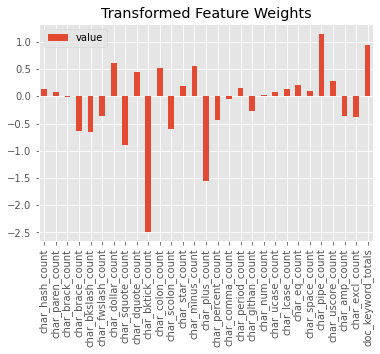

In [10]:
# Display Weights for Transformed Data
get_logreg_weights(df, tf_data_logreg_model, 'is_obf', title='Transformed Feature Weights', v=False)

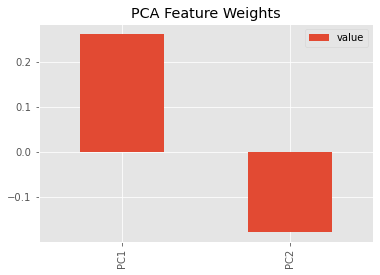

In [11]:
# Display Weights for PCA Data
get_logreg_weights(my_var.pca_with_label_df, pca_logreg_model, 'is_obf', title='PCA Feature Weights', v=False)

In the above section, we display asssociated with the logistic regression models we derived from our data sets. It's important to first delineate how logistic regression lends to classification over linear regression, for example. Linear regression fits a straight line or hyperplane, whereas logistic regression models use logistic functions to fit according to the output of a linear equation between a binary, '0' and '1'. A weight can be interpreted as a change in a value by one unit to increase the log odds ratio by the value of a corresponding weight.

In the raw data feature weights plot, you can see one of the strongest features appears to be 'char_bktick_count'. Similarly, in the Transformed Feature Weights plot, 'char_bktick_count' again has statistical significance in addition to the aggregate column we added, 'doc_keyword_sum'. The latter finding corroborates what we observed in our exploratory data analysis. Finally, looking at the Delta PCA Feature Weights plot we can see PC1 has the most significance- recall from our EDA this signifies the features, 'doc_avg_line_len' and doc_line_count', have the most weight pertaining to our study and classification of known obfuscated versus NOT obfuscated.

In summary, the 'doc_keyword_sum' feature from the transformed feature weights plot and 'doc_avg_line_len' and doc_line_count' from the PCA Delta Data set align with our exploratory analysis, whereas 'char_bktick_count' from the raw data feature weights plot presents an interesting and new result worth investigating further.

### review and rework based on decision to exclude raw data